# Advanced Lane Finding Project
## The goals / steps of this project are the following:
* **Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.**
* **Apply a distortion correction to raw images.**
* **Use color transforms, gradients, etc., to create a thresholded binary image.**
* **Apply a perspective transform to rectify binary image ("birds-eye view").**
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
___________________

## Imports

In [73]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import pickle

%matplotlib inline

## Goal 1: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

### Plot one image and evaluate it's characteristics

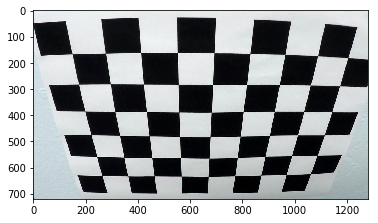

In [66]:
name = 'camera_cal/calibration2.jpg'
img = cv2.imread(name)
plt.imshow(img)

Here I can see nx = 9 and ny = 6

In [67]:
nx = 9
ny = 6

Taking inspiration from https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb for camera callibration.

Detecting corners in chessboards

In [77]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
#         write_name = 'corners_found'+str(idx)+'.jpg'
#         cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)
        
cv2.destroyAllWindows()

Using the corners detected from chessboards and using that to calliberate camera

I am showcasing a case that failed while corner detection and also saving the calibration result at **camera_cal/wide_dist_pickle.p**

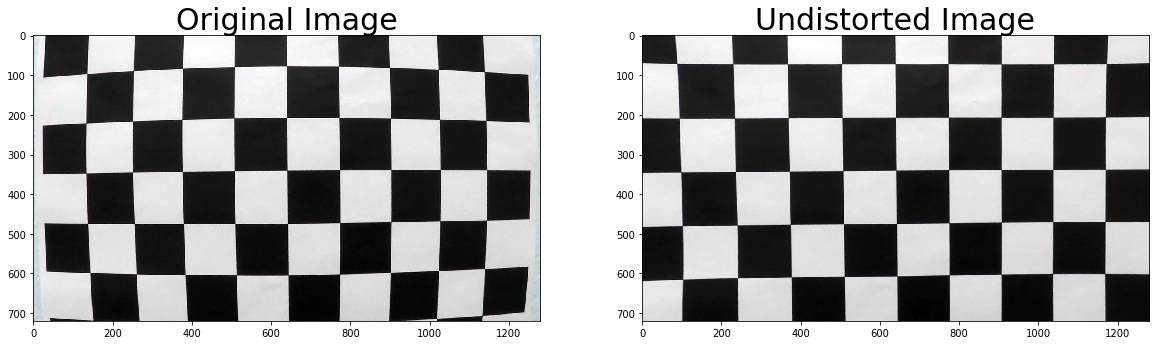

In [79]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
# cv2.imwrite('camera_cal/calibration1_undistorted.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Goal 2: Apply a distortion correction to raw images.


In [106]:
# Given an image, it undistorts an image from memory loaded mtx and dist
def undistort(img):
    img_size = (img.shape[1], img.shape[0])
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

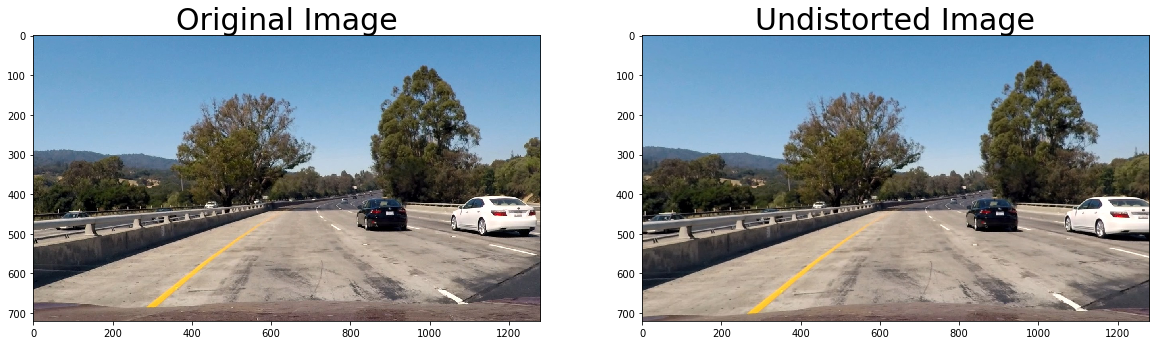

In [107]:
img = cv2.imread('test_images/test1.jpg')
dst = undistort(img)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

Now storing undistored images to **output_images** folder

In [108]:
images = glob.glob('test_images/*')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = undistort(img)
    cv2.imwrite('output_images/undistorted/' + fname.split('/')[1], dst)

## Goal 3: Use color transforms, gradients, etc., to create a thresholded binary image.

### Magnitute Thresholding

In [123]:
# Generate binary output with magnitute threshold.
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

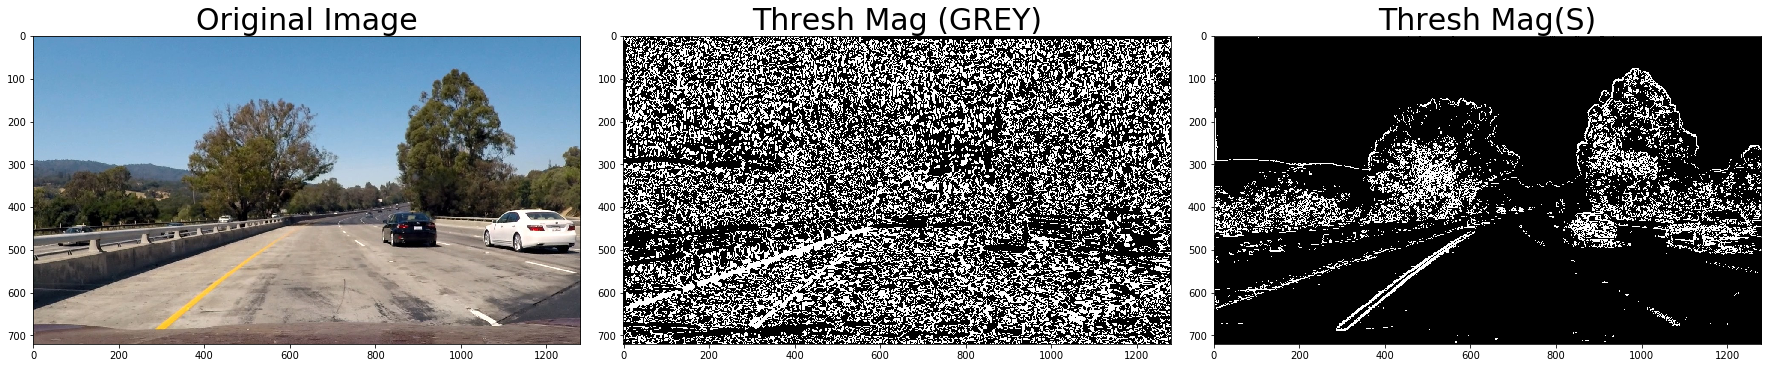

In [159]:
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
    

mag_gray_binary = mag_thresh(gray, sobel_kernel=3, mag_thresh=(20, 100))
mag_s_binary = mag_thresh(s_channel, sobel_kernel=3, mag_thresh=(20, 100))
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresh Mag (GREY)', fontsize=30)
ax3.imshow(mag_s_binary, cmap='gray')
ax3.set_title('Thresh Mag(S)', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Direction of gradient

In [155]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

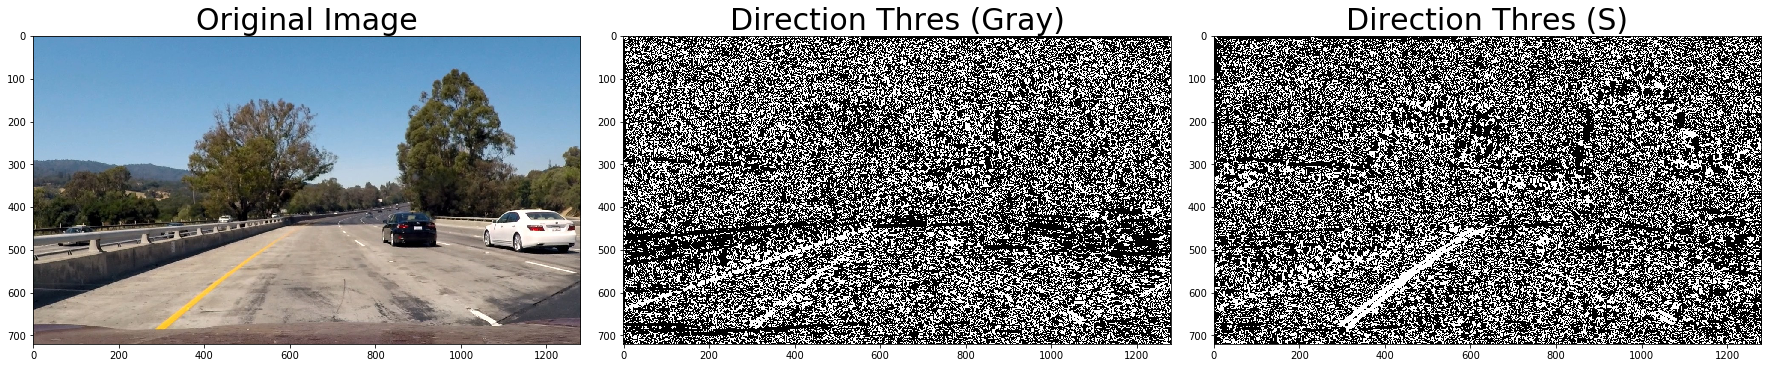

In [164]:

img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

dir_binary =dir_threshold(gray, sobel_kernel=15, thresh=(0.7, 1.3))
dir_s_binary = dir_threshold(s_channel, sobel_kernel=15, thresh=(0.7, 1.3))

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Direction Thres (Gray)', fontsize=30)
ax3.imshow(dir_s_binary, cmap='gray')
ax3.set_title('Direction Thres (S)', fontsize = 30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Combining the thresholds

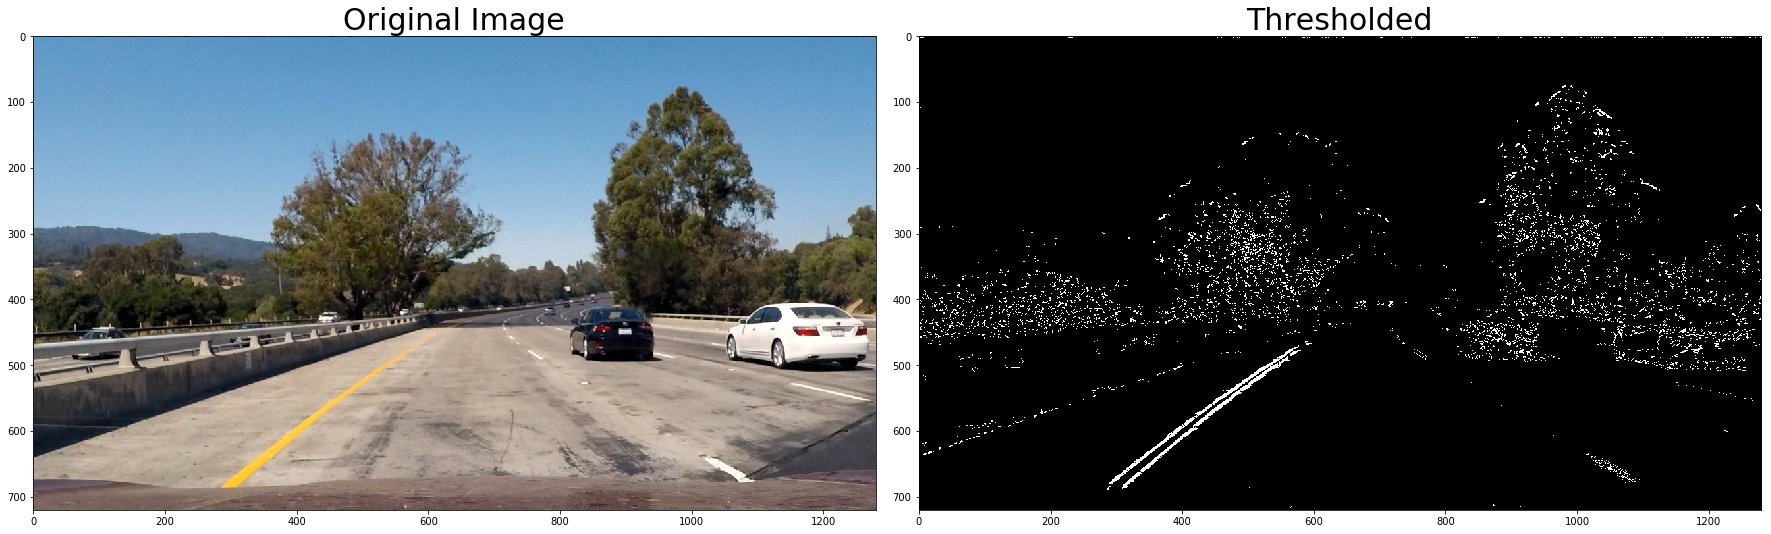

In [172]:
def combined_threshold(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    dir_s_binary = dir_threshold(s_channel, sobel_kernel=15, thresh=(0.7, 1.3))
    mag_s_binary = mag_thresh(s_channel, sobel_kernel=3, mag_thresh=(30, 100))
    
    combined = np.zeros_like(dir_s_binary)
    combined[(mag_s_binary == 1) & (dir_s_binary == 1)] = 1
    
    return combined

img = cv2.imread('test_images/test1.jpg')
combined = combined_threshold(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


Now storing undistored images to **output_images/thresholded** folder

In [173]:
images = glob.glob('test_images/*')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = combined_threshold(img)
    cv2.imwrite('output_images/thresholded/' + fname.split('/')[1], np.dstack((dst, dst, dst))*255)

## Goal 4: Apply a perspective transform to rectify binary image ("birds-eye view").

In [186]:
def draw_quadrilateral(image, points, color=[255, 255, 0], width=4):
    p1, p2, p3, p4 = points
    cv2.line(image, tuple(p1), tuple(p2), color, width)
    cv2.line(image, tuple(p2), tuple(p3), color, width)
    cv2.line(image, tuple(p3), tuple(p4), color, width)
    cv2.line(image, tuple(p4), tuple(p1), color, width)

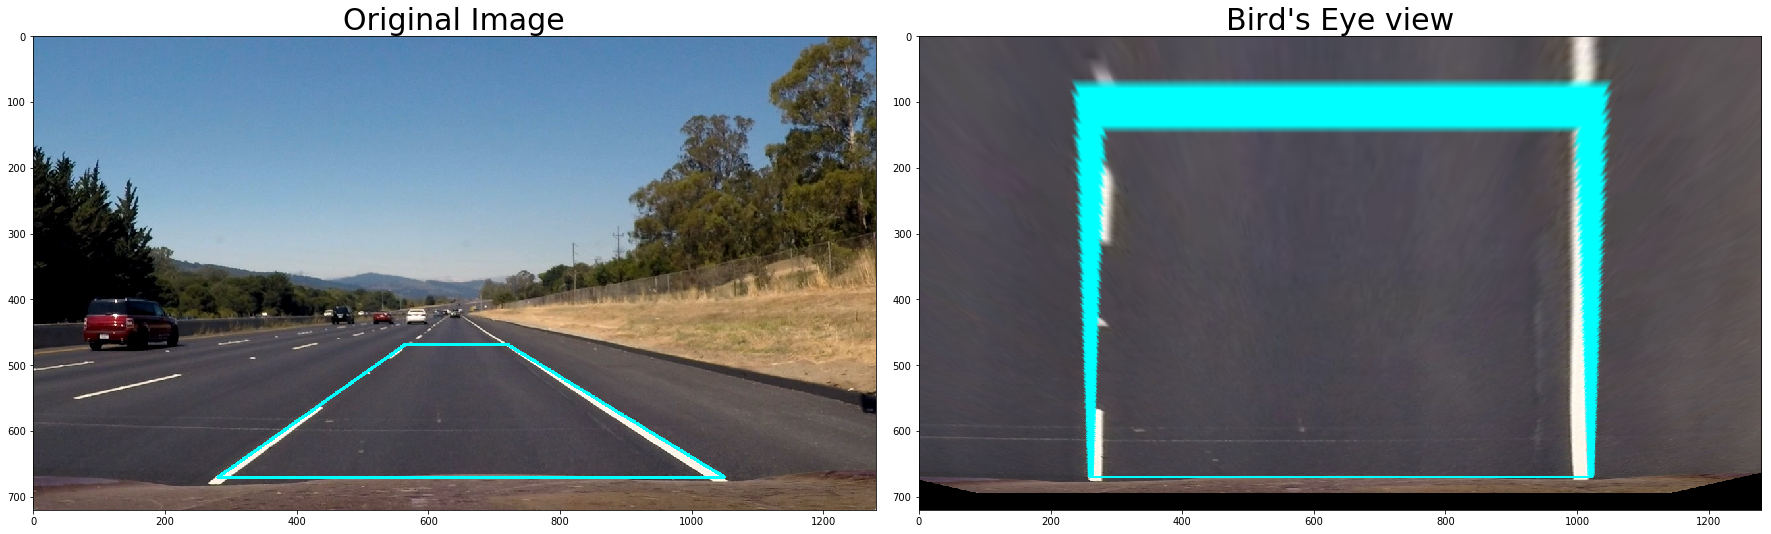

In [222]:
img = cv2.imread('test_images/straight_lines2.jpg')

height, width = img.shape[0:2]
size_top = 85
size_bottom=380
src_points = np.float32(
    [
        [(width/2) - size_top+10, height*0.65],        
        [(width/2) + size_top-5, height*0.65],        
        [(width/2) + size_bottom + 30, height-50],
        [(width/2) - size_bottom+20, height-50]
    ])

dst_points = np.float32(
    [
        [(width/2) - size_bottom, height*0.15],        
        [(width/2) + size_bottom, height*0.15],        
        [(width/2) + size_bottom, height-50],
        [(width/2) - size_bottom, height-50]
    ])

M = cv2.getPerspectiveTransform(src_points, dst_points)
Minv = cv2.getPerspectiveTransform(dst_points, src_points)

draw_quadrilateral(img, src_points)

warped_image = cv2.warpPerspective(img, M, (width, height), flags=cv2.INTER_LINEAR)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(warped_image,cv2.COLOR_BGR2RGB))
ax2.set_title("Bird's Eye view", fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
